<a href="https://colab.research.google.com/github/kumarmanishjha/pgm-prjoject_A18/blob/master/cvae_with_conv_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2018-12-11 01:56:52--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  3.05MB/s    in 29s     

2018-12-11 01:57:21 (5.64 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [2]:
!tar -zxvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

add_path = '/content/drive/My Drive/Colab Notebooks/cvae/'

# results save folder
CVAE_Fixed_results = '/content/drive/My Drive/Colab Notebooks/cvae/CVAE_Fixed_results'
CVAE_Random_results = '/content/drive/My Drive/Colab Notebooks/cvae/CVAE_Random_results'
CVAE_Results = '/content/drive/My Drive/Colab Notebooks/cvae/CVAE_Results'



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import pickle
from skimage.io import imsave
import itertools 

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, Conv2DTranspose, MaxPooling2D,  BatchNormalization, Reshape, UpSampling2D, Concatenate, Conv2D, AveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
from keras.engine.topology import Layer
from keras.optimizers import Adam

##%%
#%% CIFAR-10


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = 10

img_rows, img_cols = 32, 32
channels = 3
input_shape = (img_rows, img_cols, channels)

def load_pickle(f):
        return  pickle.load(f, encoding='latin1')

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')
    x_val = X_val.astype('float32')
    x_train /= 255
    x_test /= 255
    x_val /= 255
    

    return x_train, y_train, x_val, y_val, x_test, y_test


# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()


print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

y_train = to_categorical(y_train, num_classes)
y_val =  to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

def to_image(data, row, col, channel):
    size = data.shape[0]
    tp = np.zeros((size, row, col, channel))
    for i in range(size):
        tp[i,:,:,:] = np.transpose(np.reshape(data[i,:],(3, 32,32)), (1,2,0))
    return tp
        
x_train = to_image(x_train, img_rows, img_cols, channels)
x_val = to_image(x_val, img_rows, img_cols, channels)
x_test = to_image(x_test, img_rows, img_cols, channels)

#%% LOSS

class KLLossLayer(Layer):
    __name__ = 'kl_loss_layer'

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(KLLossLayer, self).__init__(**kwargs)

    def lossfun(self, z_avg, z_log_var):
        kl_loss = -0.5 * K.mean(1.0 + z_log_var - K.square(z_avg) - K.exp(z_log_var))
        return kl_loss

    def call(self, inputs):
        z_avg = inputs[0]
        z_log_var = inputs[1]
        loss = self.lossfun(z_avg, z_log_var)
        self.add_loss(loss, inputs=inputs)

        return z_avg
    
class GeneratorLossLayer(Layer):
    __name__ = 'generator_loss_layer'

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(GeneratorLossLayer, self).__init__(**kwargs)

    def lossfun(self, y_true, y_pred):
        loss_x = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)


        return loss_x 

    def call(self, inputs):
        y_true = inputs[0]
        y_pred = inputs[1]
        loss = self.lossfun(y_true, y_pred)
        self.add_loss(loss, inputs=inputs)

        return y_true
    
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_true)



#%%
m = 64
n_x = x_train.shape[1]
n_y = y_train.shape[1]

n_epoch = 20


latent_dim= 100


Using TensorFlow backend.


Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [6]:

#Use image and label as input together


#Build Encoder
img = Input(shape=input_shape)
label = Input(shape=(num_classes,))

c = Reshape((1, 1, num_classes))(label)
c = UpSampling2D(size=(img_rows, img_cols))(c)
en = Concatenate(axis=-1)([img, c])

en = Conv2D(128, 3, strides=(2, 2), padding='same', activation='relu')(en)


en = Conv2D(64, 3, strides=(2, 2), padding='same', activation='relu')(en)


en = Conv2D(32, 3, strides=(2, 2), padding='same', activation='relu')(en)


en = Flatten()(en)




#calculate the mu and sigmas 
mu = Dense(latent_dim, activation='linear')(en)
log_sigma = Dense(latent_dim, activation='linear')(en)

encoder = Model([img, label], mu)
print ("ENCODER")
encoder.summary()

ENCODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 1, 10)     0           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 32, 32, 10)   0           reshape_1[0][0]                  
__________________________________________________________________________________________________
co

In [18]:


#KL loss 
kl_loss = KLLossLayer()([mu, log_sigma])

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, latent_dim))
    return mu + K.exp(log_sigma / 2) * eps

# Sample z ~ Q(z|X,y)
z = Lambda(sample_z, output_shape = (latent_dim, ))([mu, log_sigma])

#decoder

#Build Decoder
dec = Input(shape=(latent_dim,))
dec_in = Concatenate(axis=-1)([dec, label])

de = Dense(4*4*128, activation='relu')(dec_in)
de = Reshape((4, 4, 128))(de)

de = Conv2DTranspose(128, 3, strides=(2, 2), padding='same', activation='relu')(de)

de = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', activation='relu')(de)

de = Conv2DTranspose(32, 3, strides=(2, 2), padding='same', activation='relu')(de)


h_decoded = Conv2DTranspose(3, 3, strides=(1, 1), padding='same' , activation='sigmoid')(de)

decoder = Model([dec, label], h_decoded)
print ("DECODER")
decoder.summary()

z_p = Input(shape=(latent_dim,))
x_f = decoder([z, label])
g_loss = GeneratorLossLayer()([img, x_f])      


enc_trainer = Model(inputs=[img, label],
                        outputs=[g_loss, kl_loss])
enc_trainer.compile(loss=[zero_loss, zero_loss],
                        optimizer=Adam(lr=2.0e-4, beta_1=0.5))



DECODER
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 110)          0           input_17[0][0]                   
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2048)         227328      concatenate_13[0][0]             
__

epochs:  0
Losses 0


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cvae/CVAE_Random_results/0_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cvae/CVAE_Random_results/0_6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cvae/CVAE_Random_results/0_12.png is a low contrast image
  warn('%s is a low contrast image'

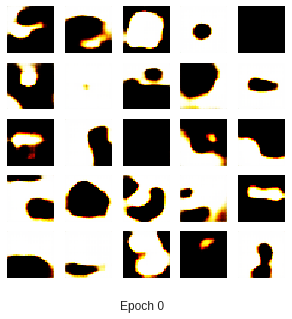

epochs:  1
Losses 0


KeyboardInterrupt: ignored

In [19]:



#%% training

def save_batch_result(batch_data, path, epoch):
    batch_size = batch_data.shape[0]
    for i in range(batch_size):
        f_name = str(epoch) + '_' + str(i) + '.png'
        img_sav = batch_data[i]
        imsave(os.path.join(path,f_name), img_sav)

def show_result(batch_data, path, epoch, show):
      size_figure_grid = 5
      fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
      for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
          ax[i, j].get_xaxis().set_visible(False)
          ax[i, j].get_yaxis().set_visible(False)

      for k in range(5*5):
          i = k // 5
          j = k % 5
          ax[i, j].cla()
          ax[i, j].imshow(batch_data[k])

      label = 'Epoch {0}'.format(epoch)
      fig.text(0.5, 0.04, label, ha='center')
      plt.savefig(os.path.join(path, str(epoch)))

      if show:
          plt.show()
      else:
          plt.close()
          
def train_on_batch(x_batch, epoch):
    x_r, c = x_batch
    x_dummy = np.zeros(x_r.shape, dtype='float32')
    z_dummy = np.zeros(z.shape, dtype='float32')

    # Train autoencoder
    enc_trainer.train_on_batch([x_r, c], [x_dummy, z_dummy])
    

    return loss


#%% Training 
n_epoch = 100


size = x_train.shape[0]
loss = 0

for epoch in range(n_epoch):
    print ("epochs: ", epoch)
    print ("Losses", loss)
    for i in range(int(size/m)):
        idx = np.random.randint(0, x_train.shape[0], m)
        imgs = x_train[idx]
        labels = y_train[idx]
        loss = train_on_batch([imgs, labels], epoch)
    #save input image
    save_batch_result(imgs[0:50], CVAE_Fixed_results, epoch)
    #save generated image
    f_latent = encoder.predict([imgs[0:50], labels[0:50]])
    f_image = decoder.predict([f_latent, labels[0:50]])
    save_batch_result(f_image, CVAE_Random_results, epoch)
    show_result(f_image, CVAE_Results, epoch, True)


#%%


